<a href="https://colab.research.google.com/github/Amelrich/Capstone-Fall-2020/blob/kassie-preprocessing/kassie_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
!pip install pandas_market_calendars

In [4]:
import pandas_market_calendars as mcal

In [5]:
# Start and End date of stock data
start_date = pd.to_datetime('1999-11-18')
end_date   = pd.to_datetime('2020-09-02')

In [7]:
# Read names of Stocks we are interested in
symbols = pd.read_csv('/sp500.csv',index_col=False)
symbols = list(symbols['Symbol'].values)
symbols = sorted(symbols)

In [8]:
symbols = ['BF-B' if x=='BF.B' else x for x in symbols]
symbols = ['BRK-B' if x=='BRK.B' else x for x in symbols]

###Set start & end date and find the trading days between them
From the `pandas_market_calendars` package, find all the trading dates given a specific range of dates

In [14]:
# get trading days calendar
def create_market_cal(start, end):
    nyse = mcal.get_calendar('NYSE')
    schedule = nyse.schedule(start, end)
    market_cal = mcal.date_range(schedule, frequency='1D')
    market_cal = market_cal.tz_localize(None)
    market_cal = [i.replace(hour=0) for i in market_cal]
    return market_cal 


# Start and End date of stock data
start_date = pd.to_datetime('1999-11-18')
end_date   = pd.to_datetime('2020-09-02')

# Create a calendar
calendar = create_market_cal(start_date, end_date)



### Split the calendar dates in chunks of length 150
We do this because we are interested in data points that capture multiple time scales. We want to capture a stocks behavior over 50 & 100 & 150 days, and have all of this information in one data point that has a fixed length of 50.

In [15]:
# divide the calendar in 150 day chunks
def divide_chunks(l, n): 
      
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 

# split trading days from start to end date in 50 day chunks
n = 150
list_of_date_chunk = list(divide_chunks(calendar, n)) 

# we skip the last date chunk bc it is not 150 days long
list_of_date_chunk = list_of_date_chunk[:-1]
len(list_of_date_chunk[-1])

150

### How we achieve multiscale data points

If you look at the fuction ```get_multiscale_values``` bellow, we notice that we want to extract infromation from a specific time window. 
* In order to capture the scale of price of 50 days we can just do `df_start_end[0:50]` and capture the first 50 consecutive days.


* In order to capture the timescale of 100 days we `df_start_end[0:100:2]`, thus each time we skip a value in between and are able to capture 100 days prices. We still have a length of 50.

Similarly for 150 days.



In [ ]:
def get_multiscale_values(df_start_end):
  days_50 = df_start_end[0:50]
  days_100 = df_start_end[0:100:2]
  days_150 = df_start_end[0:150:3]
  return days_50, days_100, days_150
  
def scrape_yahoo(stock_name, start_date, end_date):
  # scrape data of each stock from yahoo
  
  try:
    df = web.DataReader(stock_name,'yahoo', start_date, end_date)
    df = df[['Adj Close','Volume']]
    df['Symbol'] =  stock_name
    find_flag = 1
    return df, find_flag
  except KeyError:
    print("Could not find data on ".format(stock_name))
    find_flag = 0
    return pd.DataFrame(), find_flag

total_prices_list = []
total_labels_list = []

for stock_name in symbols:
  stock_df, find_flag = scrape_yahoo(stock_name, start_date, end_date)
  
  if find_flag == 0:
    print("Could not find data on {}".format(stock_name))
    continue

  tf_prices_list = []
  tf_stock_name_list = []

  for item in list_of_date_chunk:
    start = item[0]
    end = item[-1]
    
    df_start_end = stock_df.loc[start:end]
    if len(df_start_end) >= 150:
      days_50, days_100, days_150 = get_multiscale_values(df_start_end)
    else:

      continue
  
    dictionary = {'50_days': days_50['Adj Close'].values, '100_days': days_100['Adj Close'].values,
        '150_days': days_150['Adj Close'].values}
    
    datapoint = pd.DataFrame(dictionary)
    # create a tensor from those values, both prices and the stock name and add them in a list
    price_tensor = tf.convert_to_tensor(datapoint)
    stock_name_tensor = tf.convert_to_tensor(stock_name)
    tf_prices_list.append(price_tensor)
    tf_stock_name_list.append(stock_name_tensor)
  
  total_prices_list.append(tf_prices_list)
  total_labels_list.append(tf_stock_name_list)
  #print('Stock {} is done'.format(stock_name))

In [9]:
# we flatten the above total lists that contain all prices for all stocks in S&P
flattened_list_prices = [y for x in total_prices_list for y in x]
flattened_list_stock_names = [y for x in total_labels_list for y in x]

In [18]:
prices_ds =tf.data.Dataset.from_tensor_slices(tf.stack(flattened_list_prices))
names_ds =tf.data.Dataset.from_tensor_slices(tf.stack(flattened_list_stock_names))
# we create a data set with the labels and the prices
prices_names_ds = tf.data.Dataset.zip((prices_ds, names_ds))
print(prices_names_ds)

In [11]:
for price, label in prices_names_ds.take(2):
  print(price.shape, label)

(50, 3) tf.Tensor(b'A', shape=(), dtype=string)
(50, 3) tf.Tensor(b'A', shape=(), dtype=string)


<Figure size 432x288 with 0 Axes>

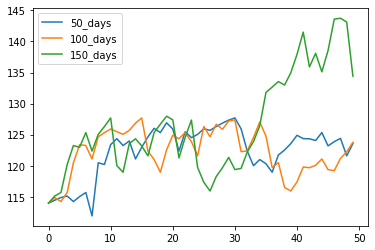

In [12]:
import matplotlib.pyplot as plt

plt.figure(); datapoint.plot(); plt.legend(loc='best')